In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth
import warnings
warnings.filterwarnings('ignore')

In [2]:
nba_2017 = pd.read_csv('NBA Players Stats 201718.csv')
nba_2017['Player'] = nba_2017['Player'].str.split('\\').str[0]
duplicated_players = nba_2017['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2017['Tm'] == 'TOT')


filtered_df = nba_2017[mask]


single_team_df = nba_2017[~duplicated_players]


nba_2017_2018 = pd.concat([filtered_df, single_team_df])
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)
nba_2017_2018 = nba_2017_2018.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2017_2018.fillna(0, inplace=True)
nba_2017_2018 = nba_2017_2018[nba_2017_2018['G'] >= 20]
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2017_2018[col] = nba_2017_2018[col] * 100

all_star_list = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 
                'Joel Embiid', 'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal',
                'Ben Simmons', 'Blake Griffin', 'Nikola Vučević', "D'Angelo Russell",
                'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George', 'LeBron James',
                'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 
                'LaMarcus Aldridge', 'DeMarcus Cousins', 'Nikola Jokić', 'Karl-Anthony Towns']
nba_2017_2018['AS_NY'] = nba_2017_2018['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [3]:
nba_2017_2018.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Luke Babbitt,28,50,14,14.3,1.8,4.3,42.3,1.2,3.1,...,0.1,1.8,1.9,0.6,0.2,0.1,0.4,1.1,5.2,0
1,Marco Belinelli,31,80,2,24.3,4.2,9.6,44.1,1.9,4.9,...,0.3,1.6,1.9,1.9,0.8,0.2,1.2,1.1,12.1,0
2,Eric Bledsoe,28,74,74,31.4,6.3,13.4,47.3,1.7,4.9,...,0.7,3.1,3.8,5.0,2.0,0.6,2.9,2.5,17.7,0
3,Trevor Booker,30,68,7,17.0,2.6,5.0,51.6,0.1,0.5,...,1.7,3.0,4.7,1.2,0.4,0.3,0.9,1.8,6.3,0
4,Avery Bradley,27,46,46,31.2,5.6,13.6,41.4,1.6,4.4,...,0.5,2.0,2.5,2.0,1.1,0.2,2.2,2.0,14.3,0


In [4]:
nba_2018 = pd.read_csv('NBA Players Stats 201819.csv')
nba_2018['Player'] = nba_2018['Player'].str.split('\\').str[0]
duplicated_players = nba_2018['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2018['Tm'] == 'TOT')


filtered_df = nba_2018[mask]


single_team_df = nba_2018[~duplicated_players]


nba_2018_2019 = pd.concat([filtered_df, single_team_df])
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)
nba_2018_2019 = nba_2018_2019.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2018_2019.fillna(0, inplace=True)
nba_2018_2019 = nba_2018_2019[nba_2018_2019['G'] >= 20]
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2018_2019[col] = nba_2018_2019[col] * 100

all_star_list = ['Kemba Walker', 'Trae Young', 'Giannis Antetokounmpo', 'Pascal Siakam', 'Joel Embiid',
                'Kyle Lowry', 'Ben Simmons', 'Jimmy Butler', 'Khris Middleton', 'Bam Adebayo', 
                'Jayson Tatum', 'Domantas Sabonis', 'James Harden', 'Luka Dončić', 'LeBron James',
                'Kawhi Leonard', 'Anthony Davis', 'Chris Paul', 'Russell Westbrook', 'Damian Lillard', 
                'Donovan Mitchell', 'Brandon Ingram', 'Nikola Jokić', 'Rudy Gobert', 'Devin Booker']
nba_2018_2019['AS_NY'] = nba_2018_2019['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [5]:
nba_2018_2019.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Ryan Anderson,30,25,8,12.9,0.8,2.8,30.4,0.4,1.6,...,0.7,1.4,2.2,0.8,0.2,0.0,0.6,1.0,2.5,0
1,Trevor Ariza,33,69,69,34.0,4.3,10.7,39.9,2.1,6.3,...,0.7,4.7,5.4,3.7,1.3,0.3,1.5,1.9,12.5,0
2,Harrison Barnes,26,77,77,32.9,5.6,13.3,42.0,2.3,5.7,...,0.7,3.9,4.7,1.5,0.6,0.2,1.3,1.6,16.4,0
3,Avery Bradley,28,63,63,30.2,3.9,9.7,40.8,1.4,3.9,...,0.7,2.1,2.8,2.4,0.7,0.3,1.4,2.7,9.9,0
4,Corey Brewer,32,31,3,15.9,1.7,4.0,43.1,0.5,1.4,...,0.8,1.6,2.5,1.3,1.0,0.2,0.6,2.0,4.9,0


**Naive Model**

In [6]:
X_train = nba_2017_2018.drop(['Player', 'AS_NY'], axis=1) 
y_train = nba_2017_2018['AS_NY']  

X_test = nba_2018_2019.drop(['Player', 'AS_NY'], axis=1)  
y_test = nba_2018_2019['AS_NY']  

y_pred = [0] * len(y_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9408983451536643
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[398   0]
 [ 25   0]]


**Base Logistic Regression Model**

In [7]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9432624113475178
Recall: 0.6
Precision: 0.5172413793103449
Confusion Matrix:
[[384  14]
 [ 10  15]]


**Feature Importances**

In [8]:
coefficients = logreg.coef_[0]


feature_names = X_train.columns


feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)


df_feature_importance = pd.DataFrame(feature_importance, columns=['Feature', 'Coefficient'])


df_feature_importance['Absolute Importance'] = df_feature_importance['Coefficient'].abs()
df_feature_importance = df_feature_importance.sort_values(by='Absolute Importance', ascending=False)
df_feature_importance

,Feature,Coefficient,Absolute Importance
0,AST,0.782852,0.782852
1,PTS,0.632340,0.632340
2,FTA,-0.576024,0.576024
3,FG,0.533266,0.533266
4,MP,-0.531159,0.531159
5,TRB,0.492185,0.492185
6,2P,0.468209,0.468209
7,DRB,0.430543,0.430543
8,TOV,0.421386,0.421386
9,eFG%,0.383320,0.383320


# AdaBoost Models

In [9]:
# AdaBoost Model (making AdaBoost models)
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

>10 0.440 (0.265)
>50 0.440 (0.150)
>100 0.400 (0.219)
>500 0.320 (0.204)
>1000 0.360 (0.196)
>5000 0.360 (0.196)


Text(0.5, 0, 'Number of trees')

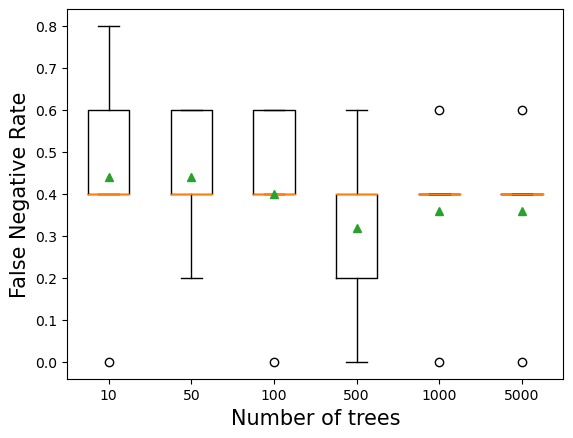

In [10]:
# Looking at number of trees (from notes)

def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rate',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.440 (0.150)
>2 0.400 (0.179)
>3 0.360 (0.233)
>4 0.360 (0.233)
>5 0.280 (0.271)
>6 0.280 (0.271)
>7 0.280 (0.271)
>8 0.280 (0.271)
>9 0.280 (0.271)
>10 0.280 (0.271)
>11 0.280 (0.271)
>12 0.280 (0.271)
>13 0.280 (0.271)
>14 0.280 (0.271)
>15 0.280 (0.271)
>16 0.280 (0.271)
>17 0.280 (0.271)
>18 0.280 (0.271)
>19 0.280 (0.271)
>20 0.280 (0.271)


Text(0.5, 0, 'Depth of each tree')

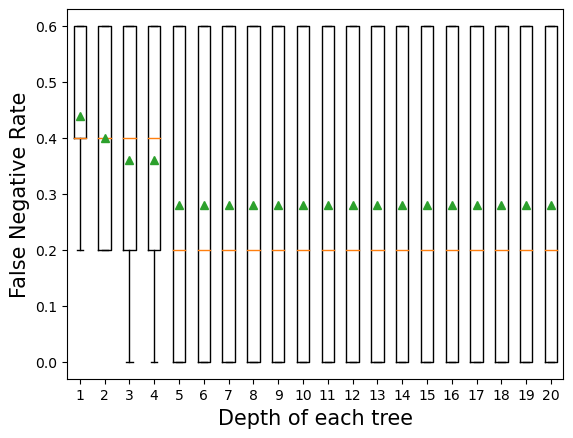

In [11]:
# Looking at max depth of trees (from notes)

def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeClassifier(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostClassifier(base_estimator=base)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores


# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rate',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.1 0.480 (0.204)
>0.2 0.520 (0.204)
>0.3 0.480 (0.271)
>0.4 0.440 (0.265)
>0.5 0.440 (0.196)
>0.6 0.400 (0.253)
>0.7 0.440 (0.265)
>0.8 0.400 (0.283)
>0.9 0.400 (0.126)
>1.0 0.440 (0.150)
>1.1 0.520 (0.098)
>1.2 0.480 (0.204)
>1.3 0.400 (0.283)
>1.4 0.320 (0.098)
>1.5 0.400 (0.283)
>1.6 0.360 (0.320)
>1.7 0.400 (0.126)
>1.8 0.440 (0.265)
>1.9 0.320 (0.204)
>2.0 0.560 (0.150)


Text(0.5, 0, 'Learning rate')

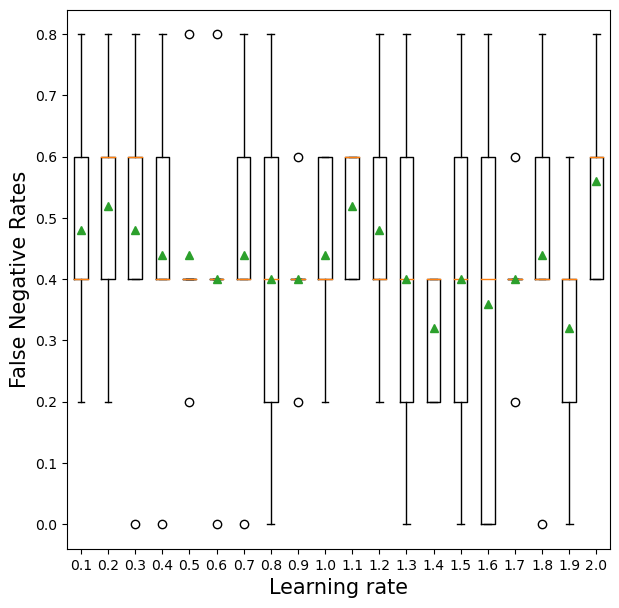

In [12]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostClassifier(learning_rate=i)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rates',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [ ]:
# Creating optimal classifier tree 
model = AdaBoostClassifier(random_state=1)

grid = dict()
grid['n_estimators'] = [50, 100, 200, 300, 400, 500, 600, 700]
grid['learning_rate'] = [0.01, 0.05, 0.1, 0.5, 1, 2]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=5),
                       DecisionTreeClassifier(max_depth=10),DecisionTreeClassifier(max_depth=15),
                       DecisionTreeClassifier(max_depth=20),DecisionTreeClassifier(max_depth=25),
                       DecisionTreeClassifier(max_depth=30),DecisionTreeClassifier(max_depth=35),
                       DecisionTreeClassifier(max_depth=40)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring= ['recall', 'accuracy'],
                           refit = 'recall',
                           verbose = True)

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
params = grid_result.cv_results_['params']

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


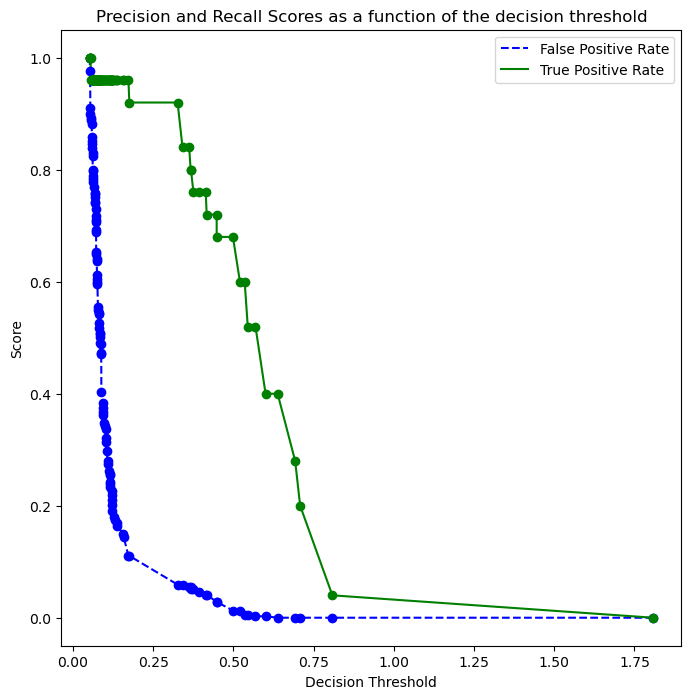

In [14]:
# Model based on the optimal parameters
ada_boost_model = AdaBoostClassifier(random_state=1, 
                                     base_estimator = DecisionTreeClassifier(max_depth=1),
                                     learning_rate=0.02,
                                     n_estimators=265).fit(X_train, y_train)


cross_val_ypred = cross_val_predict(AdaBoostClassifier(random_state=1,
                                                       base_estimator = DecisionTreeClassifier(max_depth=1),
                                                       learning_rate=0.02,
                                                       n_estimators=265),
                                    X_train,
                                    y_train,
                                    cv = 5,
                                    method = 'predict_proba')


fpr, tpr, thresholds = roc_curve(y_train, cross_val_ypred[:,1])

def plot_fpr_tpr_vs_threshold(fpr, tpr, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, fpr, "b--", label= "False Positive Rate")
    plt.plot(thresholds, tpr, "g-", label= "True Positive Rate")
    plt.plot(thresholds, fpr, "o", color = 'blue')
    plt.plot(thresholds, tpr, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
    
plot_fpr_tpr_vs_threshold(fpr, tpr, thresholds)

In [16]:
# look at feature importances
feature_importance_adaboost = pd.DataFrame({'variables' : X_train.columns,
                                            'feature_importance' : ada_boost_model.feature_importances_})

feature_importance_adaboost.sort_values('feature_importance', ascending = False)

,variables,feature_importance
23,TOV,0.245283
7,3P,0.169811
18,DRB,0.158491
25,PTS,0.090566
19,TRB,0.083019
12,2P%,0.071698
13,eFG%,0.071698
4,FG,0.056604
20,AST,0.026415
2,GS,0.011321


In [143]:
# Thresholds with TPR and FPR
all_thresholds = np.concatenate([thresholds.reshape(-1,1), tpr.reshape(-1,1), fpr.reshape(-1,1)], axis = 1)

FPR_below_5 = all_thresholds[all_thresholds[:,2] < 0.10, :]

# we want to maximize TPR while minimizing FPR so go for last one
optimal_thres = FPR_below_5[FPR_below_5.shape[0]-1][0]

Accuracy:  89.59810874704492
ROC-AUC:  0.9444723618090453
Precision:  0.3389830508474576
Recall:  0.8


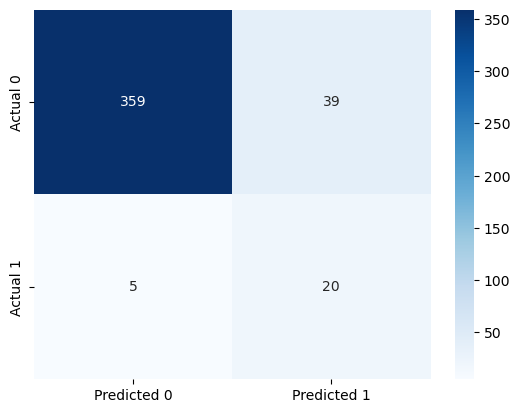

In [144]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = optimal_thres

y_pred_prob = ada_boost_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [147]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 0 and y_test.iloc[i] == 1]

print("Players predicted as 0 but actually belong to class 1:")
for player in misclassified_players:
    print(player)

Players predicted as 0 but actually belong to class 1:
Jimmy Butler
Bam Adebayo
Rudy Gobert
Brandon Ingram
Kyle Lowry
Khris Middleton
Chris Paul
Domantas Sabonis
Pascal Siakam
Jayson Tatum
Trae Young


In [148]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 1 and y_test.iloc[i] == 0]

print("Players predicted as 1 but actually belong to class 0:")
for player in misclassified_players:
    print(player)

Players predicted as 1 but actually belong to class 0:
LaMarcus Aldridge
Bradley Beal
John Collins
Stephen Curry
Kevin Durant
Paul George
Blake Griffin
Buddy Hield
Jrue Holiday
Kyrie Irving
Zach LaVine
Julius Randle
D'Angelo Russell
Klay Thompson
Karl-Anthony Towns
Nikola Vučević


In [149]:
y_pred = ada_boost_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9975845410628019
Recall: 0.96
Precision: 1.0
Confusion Matrix:
[[389   0]
 [  1  24]]


In [150]:
nba_2017_2018['Predicted'] = y_pred
nba_2017_2018['Actual'] = y_train

# False Positives: Predicted as 1 but actually 0
false_positives = nba_2017_2018[(nba_2017_2018['Predicted'] == 1) & (nba_2017_2018['Actual'] == 0)]

# False Negatives: Predicted as 0 but actually 1
false_negatives = nba_2017_2018[(nba_2017_2018['Predicted'] == 0) & (nba_2017_2018['Actual'] == 1)]

# Print the list of players
print("False Positives:")
print(false_positives['Player'])
print("False Negatives:")
print(false_negatives['Player'])

False Positives:
Series([], Name: Player, dtype: object)
False Negatives:
345    D'Angelo Russell
Name: Player, dtype: object


# Gradient Boost

In [105]:
# GradientBoost (Creating GradientBoost model)
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

### Analyzing Performance of different hyperparameters with respect to False Negative Rates

>10 0.400 (0.253)
>50 0.240 (0.294)
>100 0.280 (0.271)
>500 0.280 (0.271)
>1000 0.280 (0.271)
>5000 0.280 (0.271)


Text(0.5, 0, 'Number of trees')

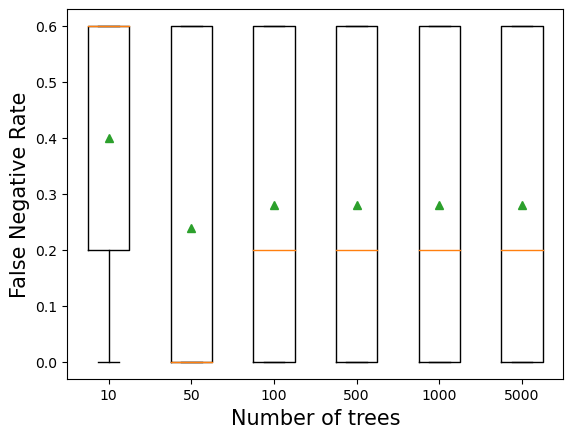

In [106]:
# Looking at number of trees (from notes)

def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n,random_state=1)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rate',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.520 (0.160)
>2 0.280 (0.271)
>3 0.280 (0.271)
>4 0.280 (0.271)
>5 0.280 (0.271)
>6 0.280 (0.271)
>7 0.280 (0.271)
>8 0.280 (0.271)
>9 0.280 (0.271)
>10 0.280 (0.271)
>11 0.280 (0.271)
>12 0.280 (0.271)
>13 0.280 (0.271)
>14 0.280 (0.271)
>15 0.280 (0.271)
>16 0.280 (0.271)
>17 0.280 (0.271)
>18 0.280 (0.271)
>19 0.280 (0.271)
>20 0.280 (0.271)


Text(0.5, 0, 'Depth of each tree')

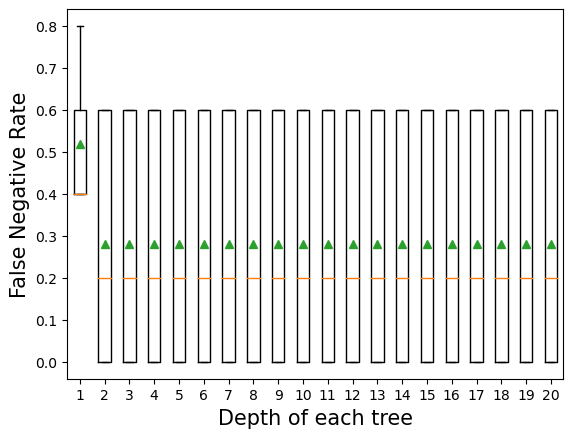

In [107]:
# Looking at depth of trees (from notes)

def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = GradientBoostingClassifier(random_state=1,max_depth=i)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rate',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.5 0.280 (0.271)
>1.0 0.280 (0.271)
>1.5 0.280 (0.271)
>2.0 0.280 (0.271)
>2.5 0.320 (0.271)
>3.0 0.320 (0.271)
>3.5 0.320 (0.271)
>4.0 0.320 (0.271)
>4.5 0.320 (0.271)
>5.0 0.320 (0.271)
>5.5 0.320 (0.271)
>6.0 0.320 (0.271)
>6.5 0.320 (0.271)
>7.0 0.320 (0.271)
>7.5 0.320 (0.271)
>8.0 0.320 (0.271)
>8.5 0.320 (0.271)
>9.0 0.320 (0.271)
>9.5 0.320 (0.271)
>10.0 0.320 (0.271)


Text(0.5, 0, 'Learning rate')

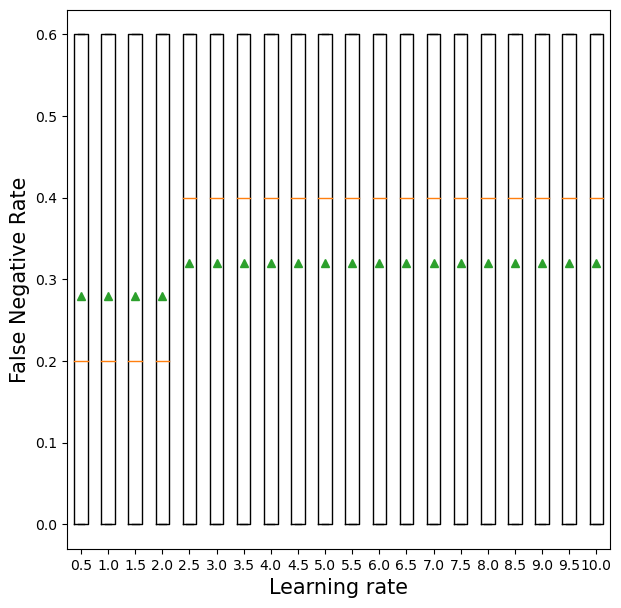

In [108]:
# Looking at Learning Rates (from notes)

def get_models():
    models = dict()
    # explore learning rates from 0 to 10 in 0.5 increments
    for i in np.arange(0.5, 10.1, 0.5):
        key = '%.1f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i,random_state=1)
    return models

# define custom scoring metric: false negative rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    # evaluate the model and collect the results
    scoring = make_scorer(false_negative_rate, greater_is_better=True)
    scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('False Negative Rate',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [151]:
# grid search for optimal hyperparameters to minimize recall and accuracy 

model = GradientBoostingClassifier(random_state=1)
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'max_depth': [5,10,15,20,25,30,35,40],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1, 2],
    'subsample': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1.0]
}

# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model,
                           param_grid = param_grid,
                           n_jobs=-1,
                           cv=cv,
                           verbose = True,
                           scoring= 'roc_auc')

# execute the grid search
grid_result = grid_search.fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 5 folds for each of 2688 candidates, totalling 13440 fits
Best: 0.989144 using {'learning_rate': 0.001, 'max_depth': 15, 'n_estimators': 100, 'subsample': 0.6}


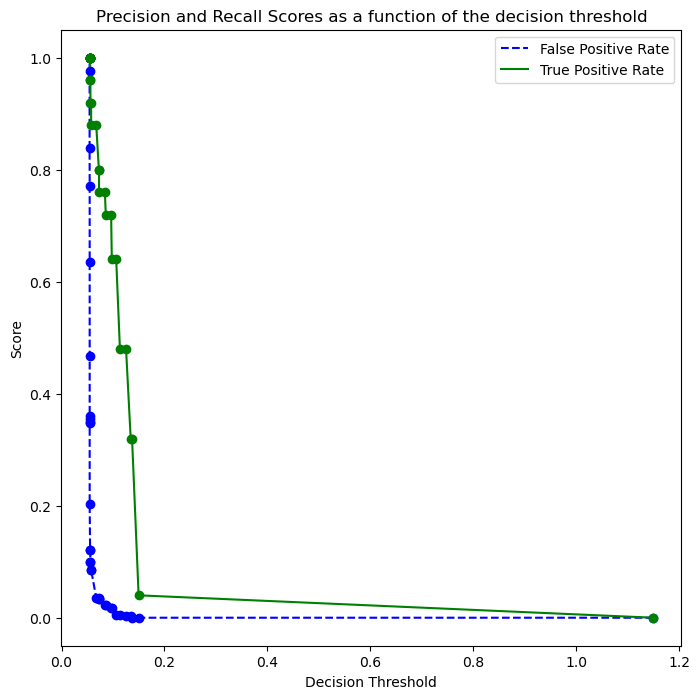

In [153]:
# Model based on the optimal parameters
gradient_boost_model = GradientBoostingClassifier(random_state=1,
                                   max_depth=15,
                                   learning_rate=0.001,
                                   subsample=0.6,
                                   n_estimators=100).fit(X_train,y_train)


cross_val_ypred = cross_val_predict(GradientBoostingClassifier(random_state=1,
                                                               max_depth=15,
                                                               learning_rate=0.001,
                                                               subsample=0.6,
                                                               n_estimators=100),
                                    X_train,
                                    y_train,
                                    cv = 5,
                                    method = 'predict_proba')


fpr, tpr, thresholds = roc_curve(y_train, cross_val_ypred[:,1])

def plot_fpr_tpr_vs_threshold(fpr, tpr, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, fpr, "b--", label= "False Positive Rate")
    plt.plot(thresholds, tpr, "g-", label= "True Positive Rate")
    plt.plot(thresholds, fpr, "o", color = 'blue')
    plt.plot(thresholds, tpr, "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
    
plot_fpr_tpr_vs_threshold(fpr, tpr, thresholds)

In [155]:
# look at feature importances
feature_importance_grad_boost = pd.DataFrame({'variables' : X_train.columns,
                                            'feature_importance' : gradient_boost_model.feature_importances_})

feature_importance_grad_boost.sort_values('feature_importance', ascending = False)

,variables,feature_importance
25,PTS,0.393900
4,FG,0.192610
13,eFG%,0.104400
23,TOV,0.063095
18,DRB,0.033833
7,3P,0.022006
20,AST,0.021990
14,FT,0.019588
12,2P%,0.018270
19,TRB,0.017635


In [156]:
# Thresholds with TPR and FPR
all_thresholds = np.concatenate([thresholds.reshape(-1,1), tpr.reshape(-1,1), fpr.reshape(-1,1)], axis = 1)

FPR_below_10 = all_thresholds[all_thresholds[:,2] < 0.10, :]

# we want to maximize TPR while minimizing FPR so go for last one
optimal_thres = FPR_below_10[FPR_below_10.shape[0]-1][0]

Accuracy:  89.12529550827422
ROC-AUC:  0.9009045226130654
Precision:  0.3157894736842105
Recall:  0.72


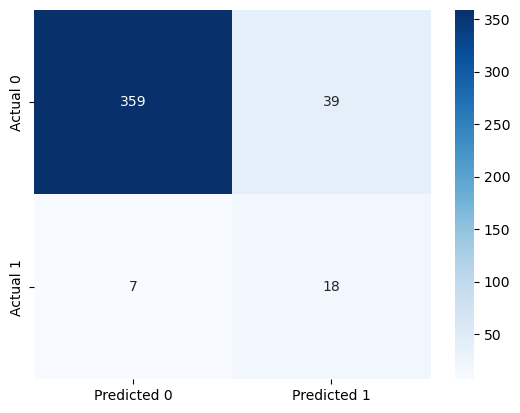

In [157]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = optimal_thres

y_pred_prob = gradient_boost_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [158]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 0 and y_test.iloc[i] == 1]

print("Players predicted as 0 but actually belong to class 1:")
for player in misclassified_players:
    print(player)

Players predicted as 0 but actually belong to class 1:
Jimmy Butler
Bam Adebayo
Rudy Gobert
Khris Middleton
Domantas Sabonis
Pascal Siakam
Jayson Tatum


In [159]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 1 and y_test.iloc[i] == 0]

print("Players predicted as 1 but actually belong to class 0:")
for player in misclassified_players:
    print(player)

Players predicted as 1 but actually belong to class 0:
Tobias Harris
DeAndre Jordan
Dennis Smith Jr.
LaMarcus Aldridge
Deandre Ayton
Bradley Beal
Clint Capela
John Collins
Mike Conley
Stephen Curry
DeMar DeRozan
Andre Drummond
Kevin Durant
De'Aaron Fox
Danilo Gallinari
Paul George
Eric Gordon
Blake Griffin
Montrezl Harrell
Buddy Hield
Jrue Holiday
Kyrie Irving
Kyle Kuzma
Zach LaVine
Kevin Love
Lauri Markkanen
CJ McCollum
Jusuf Nurkić
Victor Oladipo
Julius Randle
J.J. Redick
Rajon Rondo
Derrick Rose
D'Angelo Russell
Klay Thompson
Karl-Anthony Towns
Nikola Vučević
John Wall
Lou Williams


In [160]:
y_pred = gradient_boost_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9396135265700483
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[389   0]
 [ 25   0]]


In [161]:
nba_2017_2018['Predicted'] = y_pred
nba_2017_2018['Actual'] = y_train

# False Positives: Predicted as 1 but actually 0
false_positives = nba_2017_2018[(nba_2017_2018['Predicted'] == 1) & (nba_2017_2018['Actual'] == 0)]

# False Negatives: Predicted as 0 but actually 1
false_negatives = nba_2017_2018[(nba_2017_2018['Predicted'] == 0) & (nba_2017_2018['Actual'] == 1)]

# Print the list of players
print("False Positives:")
print(false_positives['Player'])
print("False Negatives:")
print(false_negatives['Player'])

False Positives:
Series([], Name: Player, dtype: object)
False Negatives:
12             Blake Griffin
53         LaMarcus Aldridge
60     Giannis Antetokounmpo
76              Bradley Beal
123         DeMarcus Cousins
128            Stephen Curry
130            Anthony Davis
147             Kevin Durant
150              Joel Embiid
170              Paul George
187             James Harden
214             Kyrie Irving
221             LeBron James
231             Nikola Jokić
255           Damian Lillard
261               Kyle Lowry
280          Khris Middleton
309           Victor Oladipo
345         D'Angelo Russell
355              Ben Simmons
376            Klay Thompson
380       Karl-Anthony Towns
389           Nikola Vučević
391             Kemba Walker
397        Russell Westbrook
Name: Player, dtype: object


In [162]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 0 and y_test.iloc[i] == 1]

print("Players predicted as 0 but actually belong to class 1:")
for player in misclassified_players:
    print(player)

misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 1 and y_test.iloc[i] == 0]

print("Players predicted as 1 but actually belong to class 0:")
for player in misclassified_players:
    print(player)

y_pred = gradient_boost_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("Confusion Matrix:")
print(confusion_mat)

nba_2017_2018['Predicted'] = y_pred
nba_2017_2018['Actual'] = y_train

# False Positives: Predicted as 1 but actually 0
false_positives = nba_2017_2018[(nba_2017_2018['Predicted'] == 1) & (nba_2017_2018['Actual'] == 0)]

# False Negatives: Predicted as 0 but actually 1
false_negatives = nba_2017_2018[(nba_2017_2018['Predicted'] == 0) & (nba_2017_2018['Actual'] == 1)]

# Print the list of players
print("False Positives:")
print(false_positives['Player'])
print("False Negatives:")
print(false_negatives['Player'])

Players predicted as 0 but actually belong to class 1:
Jimmy Butler
Bam Adebayo
Giannis Antetokounmpo
Devin Booker
Anthony Davis
Luka Dončić
Joel Embiid
Rudy Gobert
James Harden
Brandon Ingram
LeBron James
Nikola Jokić
Kawhi Leonard
Damian Lillard
Kyle Lowry
Khris Middleton
Donovan Mitchell
Chris Paul
Domantas Sabonis
Pascal Siakam
Ben Simmons
Jayson Tatum
Kemba Walker
Russell Westbrook
Players predicted as 1 but actually belong to class 0:
Accuracy: 0.9396135265700483
Recall: 0.0
Precision: 0.0
Confusion Matrix:
[[389   0]
 [ 25   0]]
False Positives:
Series([], Name: Player, dtype: object)
False Negatives:
12             Blake Griffin
53         LaMarcus Aldridge
60     Giannis Antetokounmpo
76              Bradley Beal
123         DeMarcus Cousins
128            Stephen Curry
130            Anthony Davis
147             Kevin Durant
150              Joel Embiid
170              Paul George
187             James Harden
214             Kyrie Irving
221             LeBron James
231    